In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from caits.visualization import plot_signal
from IPython.display import Audio

In [2]:
from caits.loading import wav_specs_check
audio_params = wav_specs_check(wav_file_path="data/dataset_speech_commands/yes/0ab3b47d_nohash_0.wav")

In [3]:
SAMPLE_RATE = audio_params["framerate"]
SAMPLE_RATE

16000

In [4]:
data_path = "data/dataset_speech_commands"

In [5]:
from caits.loading import audio_loader
cough_data_dict = audio_loader(data_path, target_sr=SAMPLE_RATE)

Loading audio files: 100%|██████████| 799/799 [00:00<00:00, 5864.61it/s]


In [6]:
from caits.dataset import Dataset

data = Dataset(
    X=cough_data_dict["X"],
    y=cough_data_dict["y"],
    id=cough_data_dict["id"],
)

data

Dataset with 799 instances

<class 'pandas.core.series.Series'>
y
no     401
yes    398
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
{'no': 401, 'yes': 398}


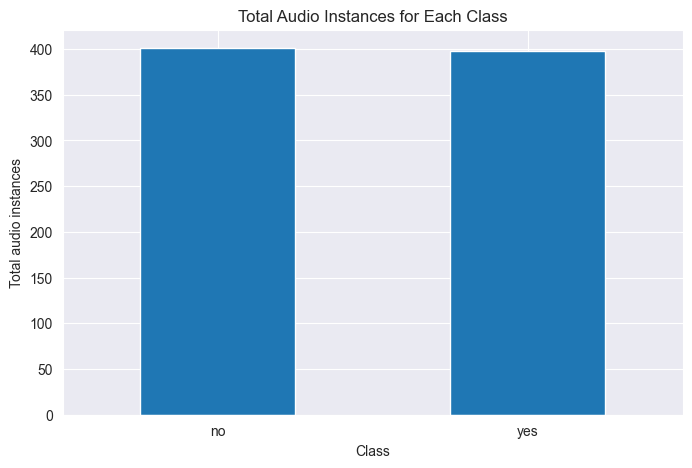

In [7]:
df = data.to_df()
df.y.value_counts().plot(kind="bar", figsize=(8, 5))

print(type(df.y))
print(df.y.value_counts())
print(type(df.y.value_counts()))
print(df.y.value_counts().to_dict())

# Set labels and title
plt.xlabel('Class')
plt.ylabel('Total audio instances')
plt.title('Total Audio Instances for Each Class')

# Display the plot
plt.grid(True)
plt.xticks(rotation=0)
plt.show()

<class 'pandas.core.series.Series'>


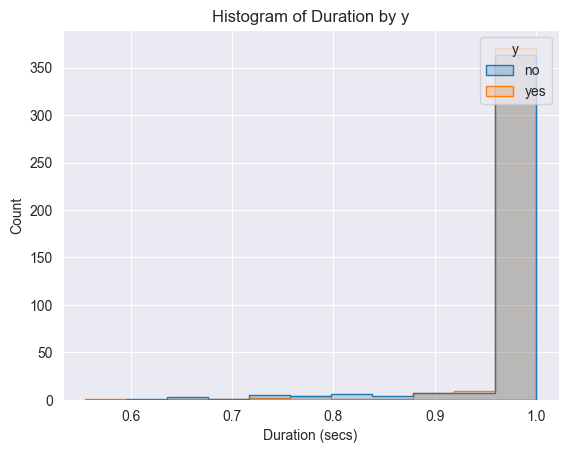

In [8]:
df["duration"] = df.X.apply(len) / SAMPLE_RATE

print(type(df.X.apply(len) / SAMPLE_RATE))

sns.histplot(data=df, x="duration", hue="y", element="step", common_norm=False)

plt.xlabel('Duration (secs)')
plt.ylabel("Count")
plt.title('Histogram of Duration by y')
plt.show()

y
no     0.109444
yes    0.109340
Name: duration_hours, dtype: float64


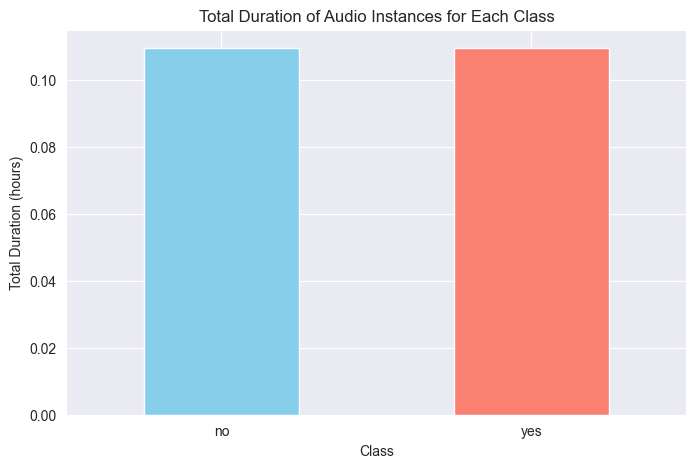

In [9]:
# Convert duration from seconds to hours
df['duration_hours'] = df['duration'] / 3600

# Group by 'y' column and calculate total duration for each class
total_duration_per_class = df.groupby('y')['duration_hours'].sum()

# Plot the total duration for each class
total_duration_per_class.plot(kind='bar', color=['skyblue', 'salmon'], figsize=(8, 5))

print(total_duration_per_class)

# Set labels and title
plt.xlabel('Class')
plt.ylabel('Total Duration (hours)')
plt.title('Total Duration of Audio Instances for Each Class')

# Display the plot
plt.grid(True)
plt.xticks(rotation=0)
plt.show()

In [10]:
WS_SECONDS = .2
OVERLAP_PERCENTAGE = 0.5 # percentage

WS_SAMPLES = int(WS_SECONDS * SAMPLE_RATE)
OVERLAP_SAMPLES = int(OVERLAP_PERCENTAGE * WS_SAMPLES)

WS_SAMPLES, OVERLAP_SAMPLES

(3200, 1600)

# Load `caits` FunctionTransformer

In [11]:
from sklearn.pipeline import Pipeline
from caits.transformers import FunctionTransformer

# Pipeline - Signal Engineering - Trimming the audio

In [12]:
instance = data[0][0]["Ch_1"].values

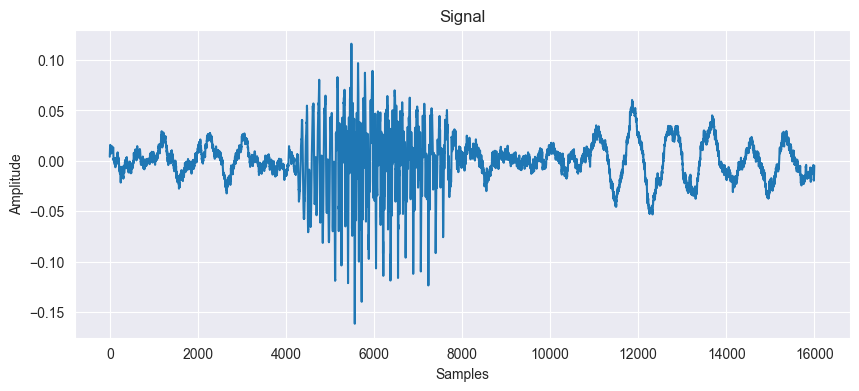

In [13]:
plot_signal(instance, SAMPLE_RATE, return_mode=False)

In [14]:
from caits.preprocessing import trim_signal

trimmer_transformer = FunctionTransformer(trim_signal, axis=0, epsilon=0.075)

In [15]:
pipe_trim = Pipeline([
    ("trimmer", trimmer_transformer)
])

In [16]:
data_trimmed = pipe_trim.fit_transform(data)

In [17]:
data_trimmed

Dataset with 799 instances

In [18]:
instance = data_trimmed[0][0]["Ch_1"].values

In [19]:
instance.shape

(1225,)

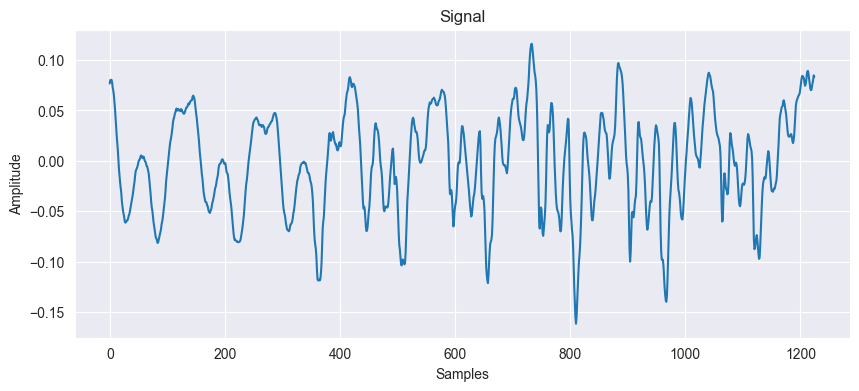

In [20]:
plot_signal(instance, SAMPLE_RATE, return_mode=False)

In [21]:
Audio(instance, rate=SAMPLE_RATE)

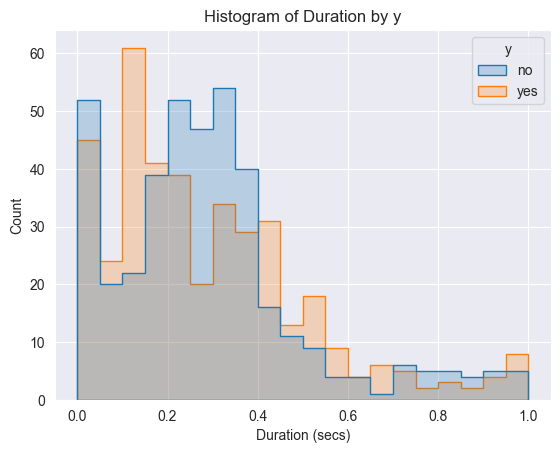

In [22]:
df = data_trimmed.to_df()

df["duration"] = df.X.apply(len) / SAMPLE_RATE

sns.histplot(data=df, x="duration", hue="y", element="step", common_norm=False)

plt.xlabel('Duration (secs)')
plt.ylabel("Count")
plt.title('Histogram of Duration by y')
plt.show()

# Pipeline - Signal Engineering - Sliding Window

In [23]:
from caits.transformers import SlidingWindow


In [24]:
sw_transformer = SlidingWindow(WS_SAMPLES, OVERLAP_SAMPLES)

In [25]:
pipe_sw = Pipeline([
    ("sw", sw_transformer),
])

In [26]:
data_sw = pipe_sw.fit_transform(data)

# Train Val Test Split

In [27]:
data_train, data_test = data_sw.train_test_split(test_size=0.2, stratify=True, random_state=42, shuffle=True)
data_train, data_val = data_train.train_test_split(test_size=0.2, stratify=True, random_state=42, shuffle=True)
data_train, data_test, data_val

(Dataset with 4499 instances,
 Dataset with 1407 instances,
 Dataset with 1125 instances)

# Pipeline - Signal Engineering - Normalization and Filtering

In [28]:
from caits.preprocessing import normalize_signal
from caits.filtering import filter_butterworth

In [29]:
normaliser_transformer = FunctionTransformer(normalize_signal)

In [30]:
lp_filt_transformer = FunctionTransformer(
    filter_butterworth, fs=SAMPLE_RATE, method="sosfiltfilt", filter_type="lowpass", cutoff_freq=7999, order=3
)

In [31]:
data_processed = pipe_sw.fit_transform(data_sw)

In [32]:
pipe_process = Pipeline([
    ("normaliser", normaliser_transformer),
    ("lp_filter", lp_filt_transformer)
])

In [33]:
# Fit transform pipeline
transformed_train = pipe_process.fit_transform(data_train)

In [34]:
X_train, y_train, files_train = transformed_train.to_numpy()
X_train.shape, y_train.shape

((4499, 3200, 1), (4499,))

In [35]:
X_train.max(), X_train.min()

(1.0050486, -1.0048082)

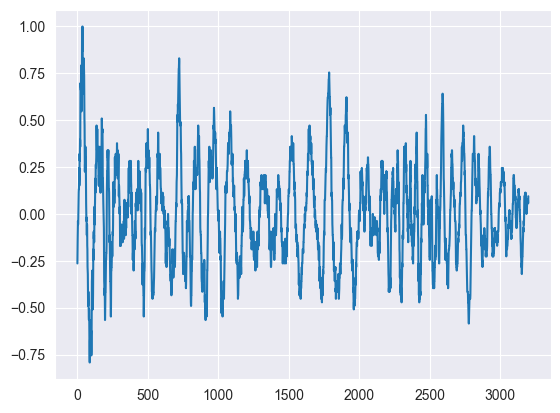

In [36]:
plt.plot(X_train[0].flatten())

# Pipeline - Final

In [37]:
pipe_final = Pipeline([
    ("trimmer", pipe_trim),
    ("sw", pipe_sw), 
    ("main processing", pipe_process)
])

In [38]:
transformed_test = pipe_final.transform(data_test)
transformed_val = pipe_final.transform(data_val)

In [39]:
from explore import classes_count, classes_total_duration_calc, instances_time_calc, wav_params_calc

In [40]:
classes_count(df)

{'no': 401, 'yes': 398}

In [41]:
classes_total_duration_calc(df)

y
no     115.950187
yes    114.686813
Name: duration, dtype: float64


(y
 no     115.950187
 yes    114.686813
 Name: duration, dtype: float64,
 'seconds')

In [42]:
instances_time_calc(df, SAMPLE_RATE)

,X,y,id,duration
0,Ch_1 0 0.076660 1 0.079956 2...,no,2f813234_nohash_1.wav,0.076563
1,Ch_1 0 0.110199 1 0.172699 2...,no,97f4c236_nohash_2.wav,0.514000
2,Ch_1 0 0.087799 1 0.104523 2...,no,5c8af87a_nohash_0.wav,0.111500
3,Ch_1 0 0.083191 1 0.080444 2...,no,7fd25f7c_nohash_2.wav,0.267688
4,Ch_1 0 0.075348 1 0.074219 2...,no,3aa6f4e2_nohash_0.wav,0.362812
...,...,...,...,...
794,Ch_1 0 0.079529 1 0.084412 2 ...,yes,1aeef15e_nohash_1.wav,0.033563
795,Ch_1 0 0.078644 1 0.096436 2...,yes,28ce0c58_nohash_3.wav,0.370688
796,Ch_1 0 0.086609 1 0.081696 2...,yes,24c9f572_nohash_2.wav,0.381125
797,Empty DataFrame Columns: [Ch_1] Index: [],yes,7d8babdb_nohash_0.wav,0.000000


In [43]:
data_path

'data/dataset_speech_commands'

In [44]:
wav_params_calc(data_path)

Loading audio files: 100%|██████████| 799/799 [00:00<00:00, 48768.85it/s]


,nchannels,sampwidth,framerate,nframes,comptype,compname,y,id
0,1,2,16000,16000,NONE,not compressed,no,2f813234_nohash_1.wav
1,1,2,16000,16000,NONE,not compressed,no,97f4c236_nohash_2.wav
2,1,2,16000,16000,NONE,not compressed,no,5c8af87a_nohash_0.wav
3,1,2,16000,16000,NONE,not compressed,no,7fd25f7c_nohash_2.wav
4,1,2,16000,16000,NONE,not compressed,no,3aa6f4e2_nohash_0.wav
...,...,...,...,...,...,...,...,...
794,1,2,16000,16000,NONE,not compressed,yes,1aeef15e_nohash_1.wav
795,1,2,16000,16000,NONE,not compressed,yes,28ce0c58_nohash_3.wav
796,1,2,16000,16000,NONE,not compressed,yes,24c9f572_nohash_2.wav
797,1,2,16000,16000,NONE,not compressed,yes,7d8babdb_nohash_0.wav


In [45]:
from plotter import plot_class_dist, plot_instance_dist

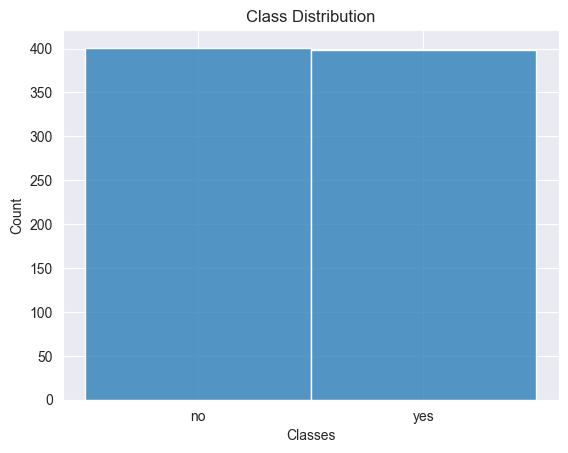

In [46]:
plot_class_dist(df)

In [47]:
total_dur, conv = classes_total_duration_calc(df)

y
no     115.950187
yes    114.686813
Name: duration, dtype: float64


In [48]:
print(total_dur)

y
no     115.950187
yes    114.686813
Name: duration, dtype: float64


In [49]:
print(type(total_dur))

<class 'pandas.core.series.Series'>


In [50]:
print(conv)

seconds


In [51]:
from plotter import plot_total_duration_per_class

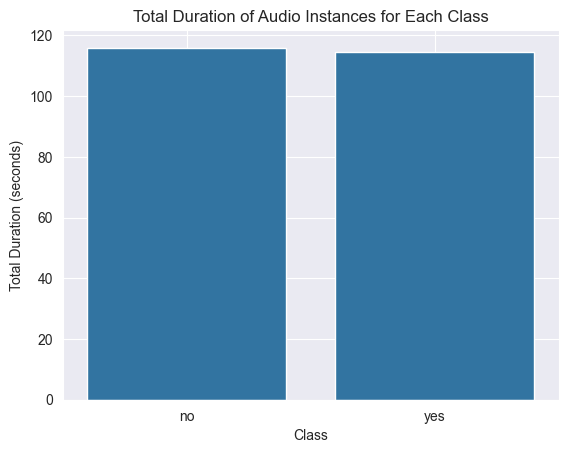

In [52]:
plot_total_duration_per_class(total_dur, conv)